In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set_context('paper')
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

import os

from pathlib import Path
import pandas as pd
import json
import math

#In-house Module Imports
from config import Configuration 

In [4]:
def plot_query_line_plot(stats_df,param_dict,naming_dict, color_dict, use_std=True):
    
    strategies = stats_df['query_strategy'].unique()

    fig = plt.figure(figsize=(param_dict['fig_width'], param_dict['fig_height']))

    for strategy in strategies:
        selected_score_data = stats_df.loc[stats_df['query_strategy'] == strategy]
        x = selected_score_data['query_iter']
        y = selected_score_data['mean']
        plt.plot(x, 
                 y,
                 linewidth=3,
                 color=color_dict[strategy],
                 label=strategy)
        if use_std:
            plt.fill_between(x, 
                             y - (0.5*selected_score_data['std']), 
                             y + (0.5*selected_score_data['std']),
                             alpha=0.2,  
                             color=color_dict[strategy],
                            )
        else:
            
            plt.fill_between(x, 
                 selected_score_data['ci95_lo'], 
                 selected_score_data['ci95_hi'],
                 alpha=1, 
                 color=color_dict[strategy],
                )

    legend = plt.legend(title="",prop={'size': param_dict['legend_size']})
    
    plt.title(f"{naming_dict['title_prefix']} w.r.t Number of Queries \n {naming_dict['fe_name']} - {naming_dict['system']} - {naming_dict['num_features']} \n #Known Apps in Training: {naming_dict['num_train_known_apps']}",fontsize=param_dict['title_size'])
    #plt.ylim([0.3, 1.01])
    plt.xlim([0, 50])

    plt.ylabel(f"{naming_dict['title_prefix']}",size=param_dict['y_label_font'])
    plt.xlabel("Number of Iterations",size=param_dict['x_label_font'])
    plt.xticks(fontsize=param_dict['x_ticks_font'])
    plt.yticks(fontsize=param_dict['y_ticks_font'])
    
    plt.show()

In [5]:
def calculate_stats(df, score_type):
    
    stats = df.groupby(['query_strategy','query_iter'])[score_type].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []
    z_star = 1.96 # 1.65: ci90

    for i in stats.index:
        m, c, s = stats.loc[i]#[2:5]
        ci95_hi.append(m + z_star*s/math.sqrt(c))
        ci95_lo.append(m - z_star*s/math.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    stats.reset_index(['query_strategy','query_iter'], inplace=True)    
    
    return stats

In [6]:
user = "aksar"
logging.warning(f'Are you sure that you are: {user}?')

2022-05-07 22:14:38,134 WARNING Are you sure that you are: aksar?


In [7]:
#Update these

PARENT_DIR = 'active_learning_experiments'
SYSTEM = 'volta'
FE_NAME = 'tsfresh'
EXP_NAME = f'{FE_NAME}_experiments'
DIR_NAME_TO_GENERATE_RESULTS = 'exp_2_active_learning'

In [8]:
OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/{PARENT_DIR}' # or feature_extraction_experiments
CV_INDEX = 0
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function

In [9]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': DIR_NAME_TO_GENERATE_RESULTS
                     })

2022-05-07 22:14:50,391 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:14:50,392 INFO    Setting directory names
2022-05-07 22:14:50,397 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:14:50,401 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning/model/p

In [10]:
result_df = pd.DataFrame()
counter = 0
result_list = []

for cv_index in [0,1,2,3,4]:

    conf = Configuration(ipython=True,
                         overrides={
                             'output_dir': Path(OUTPUT_DIR), #change
                             'system' : SYSTEM,
                             'exp_name':EXP_NAME,                                                  
                             'cv_fold':cv_index, 
                             'model_config': DIR_NAME_TO_GENERATE_RESULTS
                         }
                        )

    for filename in os.listdir(conf['results_dir']):
        
        only_filename = filename.split('.')
        splitted_filename = only_filename[0].split('#')
        train_apps = splitted_filename[0].split(':')[1]
        test_apps = splitted_filename[1].split(':')[1]
        num_unknown_test_apps = len(test_apps.split("-"))
        num_known_train_apps = len(train_apps.split("-"))        
        
        temp_csv = pd.read_csv(Path(conf['results_dir']) / filename,index_col = [0])
        temp_csv['train_apps'] = train_apps
        temp_csv['test_apps'] = test_apps        
        temp_csv['num_unknown_test_apps'] = num_unknown_test_apps
        temp_csv['num_known_train_apps'] = num_known_train_apps
        temp_csv['repeat_num'] = int(splitted_filename[8])
        
        result_list.append(temp_csv)
        
        counter += 1
               
    result_df = pd.concat(result_list, axis=0)

2022-05-07 22:14:50,839 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:14:50,840 INFO    Setting directory names
2022-05-07 22:14:50,840 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:14:50,842 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/exp_2_active_learning/model/p

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

2022-05-07 22:31:53,981 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:31:54,016 INFO    Setting directory names
2022-05-07 22:31:54,030 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:31:54,051 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 1,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_1/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_1/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_1/exp_2_active_learning/model/p

2022-05-07 22:36:50,996 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:36:51,002 INFO    Setting directory names
2022-05-07 22:36:51,012 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:36:51,018 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 2,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_2/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_2/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_2/exp_2_active_learning/model/p

2022-05-07 22:41:47,341 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:41:47,344 INFO    Setting directory names
2022-05-07 22:41:47,357 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:41:47,365 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 3,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_3/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_3/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_3/exp_2_active_learning/model/p

2022-05-07 22:47:34,853 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-07 22:47:34,857 INFO    Setting directory names
2022-05-07 22:47:34,873 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-07 22:47:34,881 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 4,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'exp_2_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_4/exp_2_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_4/exp_2_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_4/exp_2_active_learning/model/p

In [11]:
result_df.head()

,anomaly_miss_rate,anoms,dataset,false_alarm_rate,fe,feature_count,fold,macro_avg_f1_score,method,model,num_known_train_apps,num_unknown_test_apps,query_iter,query_size,query_strategy,repeat_num,test_apps,train_apps
0,0.081494,NaN,volta,0.045896,tsfresh,2000.0,0.0,0.869210,random,RandomForestClassifier,6,5,0.0,250.0,random,4,miniMD-CoMD-ft-miniGhost-miniAMR,kripke-lu-sp-bt-cg-mg
1,0.079932,NaN,volta,0.173048,tsfresh,2000.0,0.0,0.796776,random,RandomForestClassifier,6,5,0.0,250.0,random,4,miniMD-CoMD-ft-miniGhost-miniAMR,kripke-lu-sp-bt-cg-mg
2,0.108844,NaN,volta,0.020222,tsfresh,2000.0,0.0,0.892415,random,RandomForestClassifier,6,5,0.0,250.0,random,4,miniMD-CoMD-ft-miniGhost-miniAMR,kripke-lu-sp-bt-cg-mg
3,0.144082,NaN,volta,0.075247,tsfresh,2000.0,0.0,0.811448,random,RandomForestClassifier,6,5,0.0,250.0,random,4,miniMD-CoMD-ft-miniGhost-miniAMR,kripke-lu-sp-bt-cg-mg
4,0.073756,NaN,volta,0.445189,tsfresh,2000.0,0.0,0.733820,random,RandomForestClassifier,6,5,0.0,250.0,random,4,miniMD-CoMD-ft-miniGhost-miniAMR,kripke-lu-sp-bt-cg-mg


In [12]:
unique_query_strategies = result_df['query_strategy'].unique()
logging.info("Unique query strategies: %s",unique_query_strategies)
unique_methods = result_df['method'].unique()
logging.info("Unique Methods: %s", unique_methods)
unique_fe_methods = result_df['fe'].unique()
logging.info("Feature Extraction Methods: %s",unique_fe_methods)
unique_feature_counts = sorted(result_df['feature_count'].unique())
logging.info("Num Features: %s", unique_feature_counts)
unique_query_sizes = sorted(result_df['query_size'].unique())
logging.info("Unique query sizes: %s",unique_query_sizes)
unique_known_train_apps = result_df['num_known_train_apps'].unique()
logging.info("Number of Known Apps in the Training: %s", unique_known_train_apps)

# unique_random_selection = len(result_df[result_df['query_strategy'] == 'random']['repeat_num'].unique())
# logging.info("Number of Repeats for the Random Selection: %s", unique_random_selection)

# unique_folds = len(result_df[result_df['query_strategy'] != 'random']['fold'].unique())
# logging.info("Number of Folds for the Active Learning Methods: %s", unique_folds)

2022-05-07 22:53:36,549 INFO    Unique query strategies: ['random' nan 'uncertainty']
2022-05-07 22:53:57,071 INFO    Unique Methods: ['random' nan 'active_learning']
2022-05-07 22:54:17,513 INFO    Feature Extraction Methods: ['tsfresh' nan]
2022-05-07 22:54:20,485 INFO    Num Features: [2000.0, nan]
2022-05-07 22:54:23,567 INFO    Unique query sizes: [250.0, nan]
2022-05-07 22:54:25,789 INFO    Number of Known Apps in the Training: [6 2 4 8]


## Paper Plots

In [13]:
color_dict = {
                'entropy': 'tab:purple',
                'margin': 'tab:blue',    
                'uncertainty': 'orange',    
                'random': 'tab:green',
                'equal_app' : 'tab:red',
             }

param_dict = {
                'fig_width': 48,
                'fig_height': 12,
                'y_label_font': 40,
                'x_label_font': 40,
                'x_ticks_font': 35,
                'y_ticks_font': 35,    
                'legend_size': 40,
                'legend_title_size': 40,
                'title_size': 45,
                'title_pad': 40, 
                'fig_title_size': 55,
    
             }

In [14]:
selected_model = 'RandomForestClassifier'
num_query = 250
feature_count = 2000

In [15]:
naming_dict = {}
naming_dict['fe_name'] = FE_NAME
naming_dict['system'] = SYSTEM
naming_dict['num_features'] = int(feature_count)
naming_dict['num_queries'] = num_query  
naming_dict['model'] = selected_model

In [17]:
selected_result_df = result_df[(result_df['query_size'] == num_query) & (result_df['model'] == selected_model)]

In [18]:
known_2_result_df = selected_result_df[selected_result_df['num_known_train_apps'] == 2]
known_4_result_df = selected_result_df[selected_result_df['num_known_train_apps'] == 4]
known_6_result_df = selected_result_df[selected_result_df['num_known_train_apps'] == 6]

# stats_far = calculate_stats(selected_result_df, 'false_alarm_rate')
# stats_amr = calculate_stats(selected_result_df, 'anomaly_miss_rate')

In [20]:
del result_df

In [ ]:
known_2_stats_fscore = calculate_stats(known_2_result_df, 'macro_avg_f1_score')
known_4_stats_fscore = calculate_stats(known_4_result_df, 'macro_avg_f1_score')
known_6_stats_fscore = calculate_stats(known_6_result_df, 'macro_avg_f1_score')

In [ ]:
def plot_multiple_query_line_plot(fscore_df, far_df, amr_df, param_dict, naming_dict, color_dict, num_query=50, use_std=False):
    
    
    fig, axs = plt.subplots(1,3,figsize=(param_dict['fig_width'], param_dict['fig_height']))
    
    for ind, (stats_df,fig_title, fig_y_label) in enumerate(zip([fscore_df,far_df,amr_df],["2 Known Apps","4 Known Apps","6 Known Apps"],["F1-score (Macro Avg)","",""])):
        
        strategies = stats_df['query_strategy'].unique()
        
        for strategy in strategies:
            
            selected_score_data = stats_df.loc[stats_df['query_strategy'] == strategy]
            x = selected_score_data['query_iter']
            y = selected_score_data['mean']
            axs[ind].plot(x, 
                     y,
                     linewidth=3,
                     color=color_dict[strategy],
                     label=strategy)
            if use_std:
                axs[ind].fill_between(x, 
                                 y - (1*selected_score_data['std']), 
                                 y + (1*selected_score_data['std']),
                                 alpha=0.2,  
                                 color=color_dict[strategy],
                                )
            else:

                axs[ind].fill_between(x, 
                     selected_score_data['ci95_lo'], 
                     selected_score_data['ci95_hi'],
                     alpha=0.1, 
                     color=color_dict[strategy],
                    )
        axs[ind].set_title(fig_title, fontsize=param_dict['title_size'])     
        axs[ind].set_xlim([0, num_query])
        
        axs[ind].set_ylabel(f"{fig_y_label}",size=param_dict['y_label_font'])
        axs[ind].set_xlabel("Number of Iterations",size=param_dict['x_label_font'])
        axs[ind].tick_params(axis='x', labelsize=param_dict['x_ticks_font'])
        axs[ind].tick_params(axis='y', labelsize=param_dict['y_ticks_font'])                
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, ["Random","Uncertainty"], loc='lower left', 
               bbox_to_anchor=(0.38, 1.0, 0.3, 0.4), ncol=5, frameon=True, mode='None',
               prop={'size': param_dict['legend_size']}
              )
        
    #fig.suptitle(f"Active Learning with {naming_dict['model']}",fontsize=param_dict['fig_title_size'])        
    fig.suptitle(f"Unseen Applications - {naming_dict['system'].capitalize()}",fontsize=param_dict['fig_title_size'], y = 1.20) 
    plt.tight_layout()
    plt.savefig(f"/usr3/graduate/baksar/projectx/AI4HPCAnalytics/src/active_learning_experiments/plots/{naming_dict['system']}_{naming_dict['fe_name']}_unseen_apps.pdf", bbox_inches='tight')

In [ ]:
plot_multiple_query_line_plot(known_2_stats_fscore, known_4_stats_fscore, known_6_stats_fscore, 
                              param_dict, naming_dict, color_dict, 
                              num_query=num_query,
                              use_std=False)

## Plot for Each Feature Extraction Method

In [27]:
num_train_known_apps = 8 
feature_count = unique_feature_counts[0]
temp_result_df = result_df[result_df['num_known_train_apps'] == num_train_known_apps]

In [28]:
stats_fscore = calculate_stats(temp_result_df, 'macro_avg_f1_score')
stats_far = calculate_stats(temp_result_df, 'false_alarm_rate')
stats_amr = calculate_stats(temp_result_df, 'anomaly_miss_rate')

In [29]:
naming_dict = {}
naming_dict['fe_name'] = FE_NAME
naming_dict['system'] = SYSTEM
naming_dict['num_features'] = int(feature_count)
naming_dict['num_queries'] = unique_query_sizes[0]
naming_dict['num_train_known_apps'] = int(num_train_known_apps)

In [30]:
color_dict = {
                'entropy': 'tab:purple',
                'margin': 'tab:blue',    
                'uncertainty': 'orange',    
                'random': 'tab:green',
             }

In [31]:
param_dict = {
                'fig_width': 18,
                'fig_height': 12,
                'y_label_font': 45,
                'x_label_font': 45,
                 'x_ticks_font': 42,
                 'y_ticks_font': 50,    
                'legend_size': 30,
                'legend_title_size': 40,
                'title_size': 36,
                'title_pad': 40,             
             }

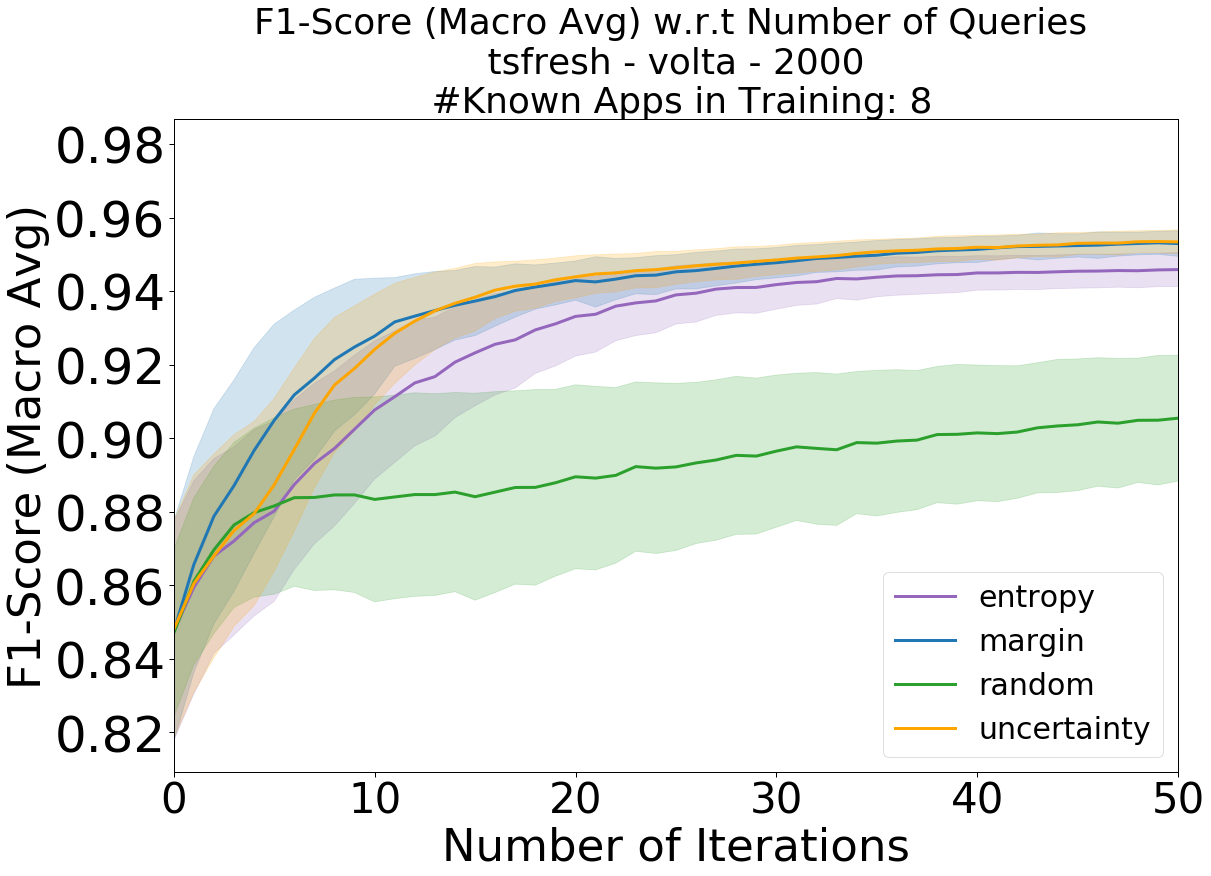

In [32]:
naming_dict['title_prefix'] = "F1-Score (Macro Avg)"
plot_query_line_plot(stats_fscore, param_dict, naming_dict, color_dict)

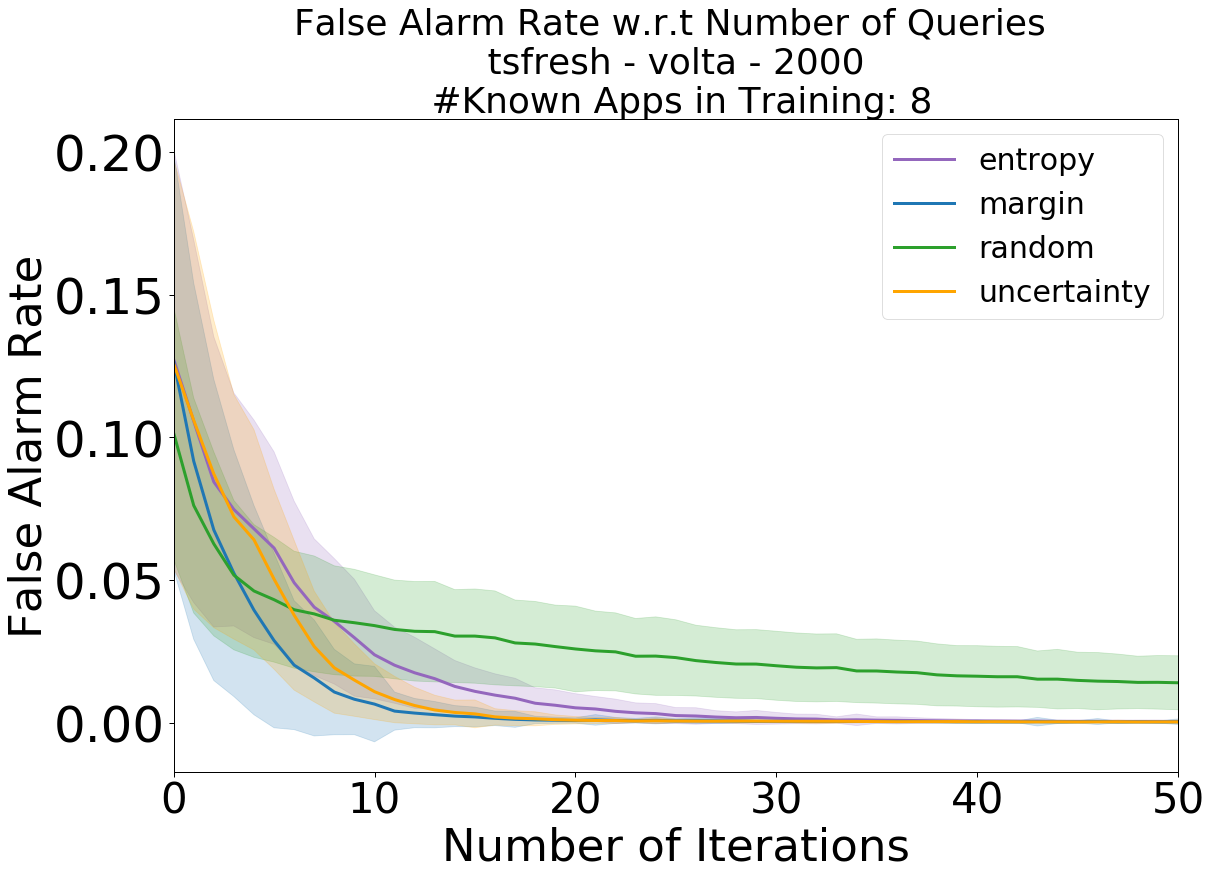

In [33]:
naming_dict['title_prefix'] = "False Alarm Rate"
plot_query_line_plot(stats_far, param_dict, naming_dict, color_dict)

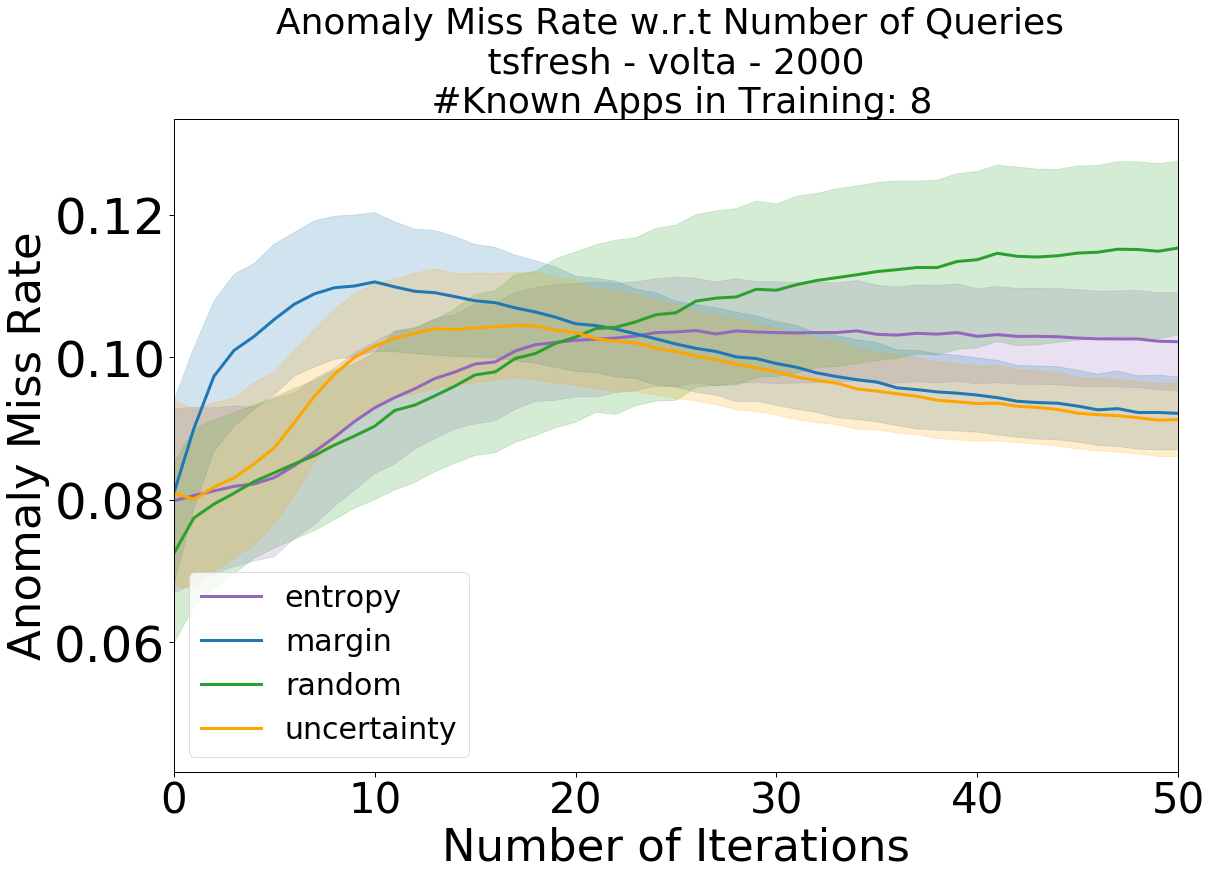

In [34]:
naming_dict['title_prefix'] = "Anomaly Miss Rate"
plot_query_line_plot(stats_amr, param_dict, naming_dict, color_dict)